# Simultaneous Localisation and Mapping (SLAM)
This notebook focuses on the agent's ability to explore a new environment and to build up a map of that environment. This is known as _Simultaneous Localisation and Mapping_ (SLAM). SLAM has received a lot of research over the years and now has very efficient and reliable algorithmic solutions available as open source packages.

This notebook builds up a NN-based solution from scratch. It contains sections for generating a training dataset from simulated 2D environments, and for training a single convolutional network for the SLAM task.

A SLAM agent has three modes of operation:
* _Exploration_ - The agent enters an entirely unknown environment, explores it, and iteratively builds a map of the environment (referred to as the _global semantic map_). In general the agent will move only a short distance from one sample to the next. At each step it uses its motor commands to estimate its new location and orientation and then revises those based on how its sensory information aligns to the map. Location tracking errors are common during this phase due to having an incomplete global map. Worse yet, they tend to accumulate, resulting in errors in the constructed global map.
* _Navigation_ - The agent has a complete global map and is using that to navigate while it performs a task, such as cleaning the floor. Like during exploration, motor commands are used to estimate the new agent location and orientation, and the sensory data plus global map are then used to improve the accuracy of that estimate. Assuming an accurate global map, tracking errors are self-corrected.
* _Global Localisation_ - The agent alrady has a complete or incomplete global map and needs to identify its current location and orientation without a previous estimate. This might occur for example when the agent is first switched on, or when it has been unexpectedly moved by an external entity. The agent searches the global map for a location that would best fit its current sensory information.

### Architecture

The global map is a gridded semantic map with the channels of each location encoding the probability distribution across the following three classes:
* Obstruction - eg: wall
* Floor - ie: open space that the agent can navigate over
* Unknown - indicates an unobserved region of the environment, or a region that has high uncertainty.

The semantic map visualises very well as an image. As such I generally refer to discrete locations as pixels.

The SLAM model is a two-headed two-tailed extension of a U-Net. It takes two image-like inputs, each going through independent down-scaling followed by combined up-scaling to a single image-like output. An additional output path is taken from the middle of the U-Net and produces a vector containing a number of values used to update location tracking.

![Image](https://raw.githubusercontent.com/malcolmlett/robovac/main/doc/Diagrams-slam-architecture.drawio.png?v=1)

The first model input is a fixed-size window taken from the constructed global map (complete or incomplete). The second input is an _occupancy map_ constructed from _Laser Distance Sensor_ (LDS) data, which represents the locations of line-of-sight obstructions only, and with considerable noise. The output map is a revised version of the semantic map window and is added back to the global map.

The second model output is the referred to as "Accept, Delta Location & Orientation" (ADLO) and contains the following components:
* Accept - binary classification probability that the agent is located within the bounds of the input semantic map.
* Delta Location (x, y) - adjustment required to the agent location tracking.
* Delta Orientation - adjustment required to the agent orientation tracking.

### Operation
Each of the operating modes are implemented as follows...

**Exploration**

The global map starts off as a small dummy region centred on the (unknown) agent's current location, with all pixels in the "unknown" state. As such the first model inputs are a blank semantic map window and an LDS map from its initial position. It's output map becomes the first populated section of the global map. The bounds of the global map are extended as the agent explores.

On each subsequent step, a sample window is taken from the global map, centred on the agent's current estimated location. The output map is as a revised version of that very same window location, and is applied as an update to the global map in the same location. If tracking was perfect then the LDS map input should overlay precisely over the semantic window input. In practice there is always some small error. The second output from the model measures that error and is used to update the estimated location.

**Navigation**

During navigation the global map is considered complete, however the environment may change over time (eg: furniture moved or people, pets and toys coming and going). Additionally, the global map may have errors due to uncorrected tracking errors during exploration. For those reasons, the model is continued to be used in an exploration mode even once the global map is complete, enabling it to continuously revise the map.

**Global Localisation**

This is triggered when the agent first switches on, and during exploration and navigation when it identifies that it has been unexpectedly moved. The second model output includes an "accept" binary classification.

During global localisation, many window samples are taken from the global map and supplied to the model in turn along with the current LDS data. At each sample location the model outputs a prediction of whether the LDS data reflects the agent being present somewhere within that sample window. The sample location with the highest likelihood is "accepted". At that point the location and orientation tracking correction outputs are used to compute the first estimate of the agent's true location and orientation.

During this first phase of global localisation, the agent's orientation is unknown and thus the LDS map constructed from the raw range data may have any orientation relative to the map. Consequently the model's tracking updates will be of low accuracy. To improve that initial estimate, the model is now used again in navigation mode with a newly sampled semantic map window and a newly constructed LDS map (with adjusted orientation). This time the model should produce accurate updates to location and orientation tracking.

There are two final points to make in relation to global localisation. Firstly, during normal exploration and navigation, the "accept" binary classification is used to continously check that the LDS map is consistent with the current tracked location. If the agent is unexpectedly moved, the model will return a low probability "accept" and the agent switches into global localisation mode. Secondly, if all samples taken during global localisation fail to reach a certain threshold, this could be used as an indication that the agent has been moved into an entirely unexplored environment and that it should start construction of a separate global map.

### Caveats
* I find I need to run this on a High-RAM environment within Colab. There seems to be a memory leak during model training that crops up on a normal environment and causes it to get OOM-killed before training completes. Frustratingly the memory leak doesn't occur when on a High-RAM, showing that it doesn't fundamentally need the extra cost of using High RAM.

In [ ]:
# Clone repo and load its modules

import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout be28234
!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam_models
import slam_data
from importlib import reload
reload(lds)
reload(slam_models)
reload(slam_data)

Cloning into 'repo'...
remote: Enumerating objects: 745, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 745 (delta 126), reused 139 (delta 68), pack-reused 518 (from 1)
Receiving objects: 100% (745/745), 61.26 MiB | 19.51 MiB/s, done.
Resolving deltas: 100% (393/393), done.
Already up to date.


<module 'slam_data' from '/content/repo/slam_data.py'>

In [ ]:
# Load standard libraries

!pip install -Uqq ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import os
import math
import ipdb
import tqdm
import time
import gc
from timeit import default_timer as timer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.3 MB/s eta 0:00:00


In [ ]:
# optionally, run test suites

import slam_data_test
import slam_motion_test
slam_data_test.run_test_suite()
slam_motion_test.run_test_suite()

## Dataset

There are many 3D SLAM datasets available online for the development of self-driving cars, but I was unable to find any available datasets for the 2D SLAM that robovacs use. Thus all data is simulated.

**Floorplans**

Simulated data for this project starts with floorplans. As I am doing this with the intent to replace the AI in an existing robovac, I used its existing mobile app interface as a basis. It builds its map as a grid and displays that as an image having a resolution of 47.4mm per pixel.

Currently I have just one floorplan that I have drawn myself. But I will be creating more. The original floorplan is a grayscale image with levels indicating the semantic meaning:

![Image](https://raw.githubusercontent.com/malcolmlett/robovac/main/data/experimental-floorplan2.png?v=1)

It has the following specs:
* 294px width x 139px height
* 13.94m x 6.59m @ 47.4mm/px

Once that is converted to a semantic map, it displays quite nicely in colour via `plt.imshow()`...

RGB encoded:     shape=(139, 294, 3), dtype=uint8, value range: 0 - 255
one-hot encoded: shape=(139, 294, 3), dtype=float32, value range: 0.0 - 1.0


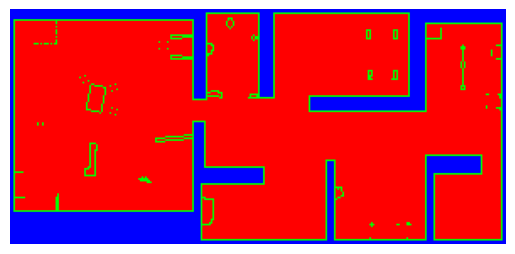

In [ ]:
# Load floorplan
floorplan = Image.open('repo/data/experimental-floorplan2.png')
floorplan = np.array(floorplan, dtype=np.uint8)
print(f"RGB encoded:     shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")
floorplan = slam_data.one_hot_encode_floorplan(floorplan).numpy()
print(f"one-hot encoded: shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

plt.imshow(floorplan)
plt.axis('off')
plt.show()

**Laser Range Data**

From my existing robovac published specs, the only information I have is that it uses LDS - Laser Distance Sensor. As it's a cheap model I expect it to use an easily available off-the-shelf module. The [Robotis LDS-01](https://emanual.robotis.com/docs/en/platform/turtlebot3/appendix_lds_01/) self-contained LDS unit is the most obvious contender.

![LDS-01](https://emanual.robotis.com/assets/images/platform/turtlebot3/appendix_lds/lds_small.png)

This unit has a single horizontally facing laser mounted on a spinning base that provides access to 360° range. It measures distance by the time it takes for a laser pulse to be reflected back of whatever surface it happens to hit. Key specs are:
* Rotates at 300RPM = 5 complete sample-sets per second
* Angular resolution: 1 degree = 360 samples per revolution
* Distance range: 120mm to 3500mm
* Distance accuracy (120mm to 500mm): ±15mm
* Distance accuracy (500mm+): ±5.0%

This can be easily simulated for a given agent location and orientation on a floorplan by tracing 360 rays from the agent location, measuring the distance to obstructing pixels in the floorplan, adding noise, and nillifying values that fall outside of the 120mm to 3500mm range (via `np.nan`). It results in a size-360 vector of floats with the first value representing the distance at 0° relative to the agent's orientation.

To make this convenient for a CNN, the LDS range data can then mapped onto a black-and-white image representing an _obstruction map_. At a max distance of 3.5m, and a pixel resolution of 47.4mm/px, this becomes a square `149 x 149` array.



range_data: shape=(360,), dtype=float64, value range (mm): 757.9910340776318 - 3467.404307145689
lds_map: shape=(149, 149), dtype=float32, value range: 0.0 - 1.0


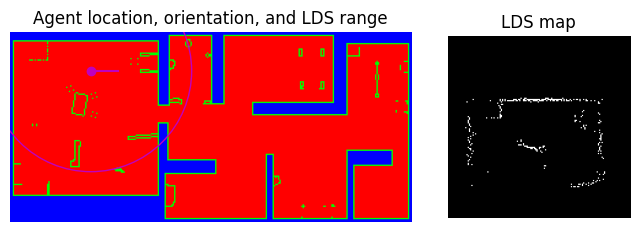

In [ ]:
reload(lds)
location_px = np.array([floorplan.shape[1], floorplan.shape[0]]) * np.array([0.2, 0.2])   # 20% to right and 20% down
angle = 0.0  # radians
occupancy_map = floorplan[..., slam_data.__OBSTRUCTION_IDX__]  # get just the walls
range_data = lds.lds_sample(occupancy_map, centre=location_px * lds.__PIXEL_SIZE__, angle=angle)
print(f"range_data: shape={range_data.shape}, dtype={range_data.dtype}, value range (mm): {np.nanmin(range_data)} - {np.nanmax(range_data)}")
lds_map = lds.lds_to_occupancy_map(range_data, angle)
print(f"lds_map: shape={lds_map.shape}, dtype={lds_map.dtype}, value range: {np.min(lds_map)} - {np.max(lds_map)}")

plt.figure(figsize=(8,3))

angle_loc = location_px + np.array([np.cos(angle), np.sin(angle)]) * 20
plt.subplot(1,3,(1,2))
plt.title('Agent location, orientation, and LDS range')
plt.imshow(floorplan)
plt.plot(location_px[0], location_px[1], 'mo')
plt.plot([location_px[0], angle_loc[0]], [location_px[1], angle_loc[1]], 'm')
plt.gca().add_artist(plt.Circle((location_px[0], location_px[1]), lds.__MAX_DISTANCE__ / lds.__PIXEL_SIZE__, color='m', fill=False))
plt.axis('off')

plt.subplot(1,3,3)
plt.title('LDS map')
plt.imshow(lds_map, cmap='gray')
plt.axis('off')

plt.show()

## Training Dataset
The training dataset needs to simulate all the different kinds of situations that can occur throughout any of the 3 operational modes. The dataset will contain many samples from different locations and orientations around the simulated floorplan(s). It will need to contain the input semantic map window and simulated LDS map input, along with the expected output map and output ADLO values.

Each training sample is encoded in the following data structure:
* `(input_tuple, output_tuple, metadata) = ((input_map, lds_map), (output_map, adlo_output), metadata)`

where:
* `input_map` = (149, 149, 3) input semantic map window
* `lds_map` = (149, 149) input LDS map
* `output_map` = (149, 149, 3) output semantic map window
* `adlo_output` = (4,) output ADLO vector
* `metadata` = (8,) vector with extra information used during an extra stage in a customised training loop, but omitted when feeding the dataset to `model.fit()`. Contains:
  * `[0]`: floorplan id
  * `[1]`: sample type - see below for explanation
  * `[2]`: input map centre x (physical units)
  * `[3]`: input map centre y (physical units)
  * `[4]`: input map orientation (radians)
  * `[5]`: ground truth agent location x (physical units)
  * `[6]`: ground truth agent location y (physical units)
  * `[7]`: ground truth agent orientation (radians)

I randomly generate 1000 samples from the floorplan. There are four different scenarios ("sample types") that I simulate. They're best explained with some visuals, so let's load or generate the dataset first.

In [ ]:
# Load training data if available, OR otherwise generate it from scratch (takes a few seconds)
if os.path.isfile('repo/data/experimental-slam-training-data5.npz'):
  train_data = slam_data.load_dataset('repo/data/experimental-slam-training-data5.npz')
else:
  print(f"Sorry, pre-generated dataset not available, you'll need to generate it.")
  floorplan = Image.open('repo/data/experimental-floorplan2.png')
  floorplan = np.array(floorplan, dtype=np.uint8)
  floorplan = slam_data.one_hot_encode_floorplan(floorplan).numpy()

  np.random.seed(0)  # for consistency
  train_data = slam_data.generate_training_data(floorplan, 1000)
  slam_data.validate_dataset(train_data)

  # Uncomment to save the dataset for later
  #slam_data.save_dataset(train_data, 'repo/data/experimental-slam-training-data5.npz')

Loaded:
  input_maps:  (1000, 149, 149, 3) x float32
  lds_maps:    (1000, 149, 149) x float32
  output_maps: (1000, 149, 149, 3) x float32
  adlos:       (1000, 4) x float32
  metadatas:   (1000, 8) x float32
Dataset loaded from repo/data/experimental-slam-training-data5.npz


**Sample Type 0**
  
Simulates the first stage of exploration mode where the agent is placed into an unknown environment with no pre-existing global map.
* The input semantic map window is blank (all pixels = "unknown"), and the model is expected to generate a first output semantic map based on the LDS data.
* LDS map input is rotated according to the agent's ground-truth orientation.
* The output map is taken as a sample from the ground-truth global semantic map, rotated according to the agent's orientation (it has no tracking information and so during operation this first output map would set the orientation of all future revisions), and then clipped to the max LDS range. This creates a semi-circular section of semantic map.
* Accept = 1.0 (True) - the model should accept this input
* DLO values are zero. There's no existing tracking, so nothing to revise.

When generating output maps for the training data, I don't attempt to emulate which sections of the map would or would not be observable based on obstructions. This simplifies the code considerably, as I only need to take a clipped section out of the ground truth map. Otherwise I would in effect need to build a part of the SLAM algorithm into the data generation. Furthermore, it encourages the model to take advantage of the capabilities of CNNs to learn the common structures of buildings and to "guess" the locations of walls that it cannot see.


input_map:  (149, 149, 3)
lds_map:    (149, 149)
output_map: (149, 149, 3)
adlo:       [1. 0. 0. 0.]
metadata:   [2.0000000e+00 0.0000000e+00           nan           nan           nan
 8.2396826e+03 5.5399946e+03 2.2490387e+00]


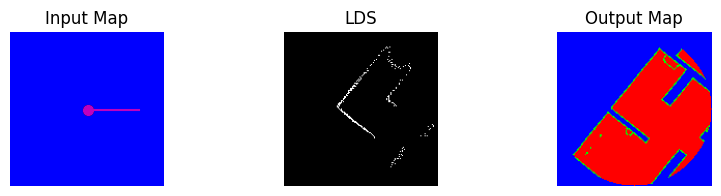

input_map:  (149, 149, 3)
lds_map:    (149, 149)
output_map: (149, 149, 3)
adlo:       [1. 0. 0. 0.]
metadata:   [2.0000000e+00 0.0000000e+00           nan           nan           nan
 1.2064993e+04 1.7325601e+03 2.9138200e+00]


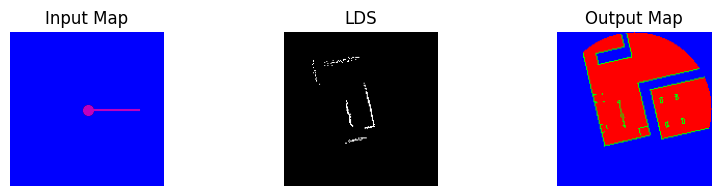

In [ ]:
slam_data.show_dataset(train_data, num=2, sample_types=0)

**Sample Type 1**

Simulates normal SLAM during both exploration and navigation modes when either a complete or incomplete global map is available. Here we have a ground-truth location and orientation of the agent, and simulated tracked location/orientation. To simulate both tracking errors and the model needing to predict accurate DLO values to correct those errors, a small normally distributed error is added to the tracked location and orientation relative to the ground-truth values.

* a window sample is taken as input semantic map from the global map according to the tracked agent location.
* during initial training, that same input map is then used as the expected output map
* the LDS map is centred on the ground-truth location of the agent. It is oriented according to the global map, but rotated slightly according to the emulated tracking error.
* Accept = 1.0 (True) - the model should accept the input map
* DLO = expected correction required to tracked location and orientation

There are two problems with the input semantic maps during initial training. During normal operation, the global map is generated by the model, and thus semantic map inputs to the model are usually constructed from the outputs of the model on prior inputs. During initial training we don't have any information about what those outputs will look like, and thus our simulated input maps lack the kinds of noise and uncertainty that would be present in the real world. Furthermore, we are not simulating the effects of partially complete global maps resulting in partially complete input semantic maps.

Rather than trying to algorithmically simulate more realistic input semantic maps, later on we shall use a custom training loop where we incrementally revise the dataset using real model outputs.

In the plots below, the black circle reflects the tracked location and the magenta circle reflects the ground-truth location. The angle of the line extending from the magenta circle reflects the direction and magnitude of simulated orientation tracking error.

input_map:  (149, 149, 3)
lds_map:    (149, 149)
output_map: (149, 149, 3)
adlo:       [ 1.         -0.04257149 -0.08866958  0.0635903 ]
metadata:   [ 2.0000000e+00  1.0000000e+00  3.2739753e+03  5.3642241e+03
  0.0000000e+00  2.9732466e+03  4.7378540e+03 -4.6301708e-01]


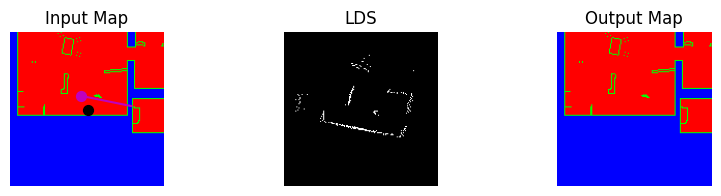

input_map:  (149, 149, 3)
lds_map:    (149, 149)
output_map: (149, 149, 3)
adlo:       [ 1.0000000e+00 -4.5766373e-04  2.0432066e-02  4.3668937e-02]
metadata:   [ 2.0000000e+00  1.0000000e+00  1.1866017e+04  2.6124204e+03
  0.0000000e+00  1.1862783e+04  2.7567542e+03 -5.7919192e-01]


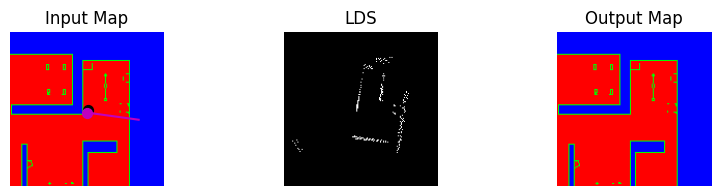

In [ ]:
slam_data.show_dataset(train_data, num=2, sample_types=1)

**Sample Type 2**

Simulates a state during global localisation mode where the agent is present somewhere within the provided semantic map window. The agent has no current tracking estimate of its location or orientation, and thus the input semantic map window and LDS map do not coincide w.r.t. location or orientation, but there is a significant overlap.
* An input semantic map window is taken from a uniform random location somewhere near the agent location
* The LDS map is taken from a separate random location, and given a random rotation uniformly chosen within 0° to 360°.
* Accept = 1.0 (True) - the model should accept this sample location
* DLO = expected approximate correction required to establish a new tracked location and orientation

In this operating mode the map output will be ignored. As such, the output map in the sample is blanked out (all pixels = "unknown"). This provides an indication to the loss function to ignore the generated output map.

In the plots below, the black and magenta indicators have the same meanings as for Sample Type 1.

input_map:  (149, 149, 3)
lds_map:    (149, 149)
output_map: (149, 149, 3)
adlo:       [ 1.          0.06650611 -0.1320825  -0.31531525]
metadata:   [2.0000000e+00 2.0000000e+00 1.3173024e+04 1.5449518e+03 0.0000000e+00
 1.3642829e+04 6.1190906e+02 2.2837534e+00]


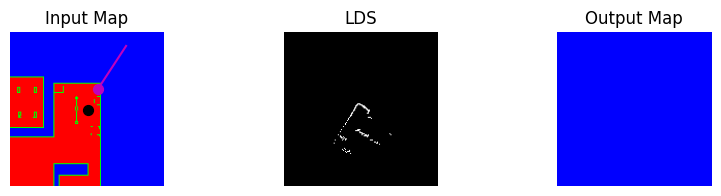

input_map:  (149, 149, 3)
lds_map:    (149, 149)
output_map: (149, 149, 3)
adlo:       [ 1.          0.08753846  0.48659375 -0.07261062]
metadata:   [2.0000000e+00 2.0000000e+00 5.6892510e+03 1.7544061e+03 0.0000000e+00
 6.3076309e+03 5.1917485e+03 1.1705631e+00]


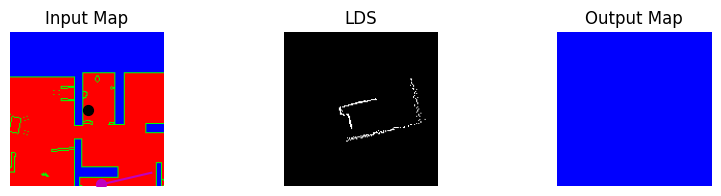

In [ ]:
slam_data.show_dataset(train_data, num=2, sample_types=2)

**Sample Type 3**

Simulates the state during global localisation where the agent is not present anywhere within the provided semantic map window, or that there is only a very minor overlap between the extent of the LDS range data and the semantic map window.

* An input semantic map window is taken from a uniform random location anywhere within the floorplan except near the agent location
* The LDS map is taken from a separate random location, and given a random rotation uniformly chosen within 0° to 360°.
* Accept = 0.0 (False) - the model should reject this sample location
* DLO = zeroed-out, but ignored by the loss function during training

Here only the "accept" output is important, as the model must "reject" the input semantic map. The loss function will ignore the model output DLO values during training for any training samples where accept=0.

As for Sample Type 2, the output map would be ignored during actual operation in this scenario, and thus I initially blanked out the output map in the dataset. However, after some experimentation I found that training is slightly better if I include an output map for this sample type. The reason is that otherwise only 50% of training samples have an output map, and this slows down training of the output map prediction. We definitely can't expect an output map for Sample Type 2 because it is ambiguous whether the output map should be based on the input semantic map window or the LDS data. However, for Sample Type 3, the output map unambigously should be from the LDS data alone, as we are rejecting the semantic map input. Conceptually, for this sample type the output map could be used if it's determined that the agent has entered a new environment. Thus I follow the same output map construction as for Sample Type 0.

In the plots below, the yellow-cross is used as a visual indicator that the model should reject the input map. There are no location/orientation markers as any DLO outputs should be ignored.


input_map:  (149, 149, 3)
lds_map:    (149, 149)
output_map: (149, 149, 3)
adlo:       [0. 0. 0. 0.]
metadata:   [ 2.0000000e+00  3.0000000e+00  9.9078851e+02  5.3716772e+03
  0.0000000e+00  7.7039824e+03  5.1253242e+03 -2.9795210e+00]


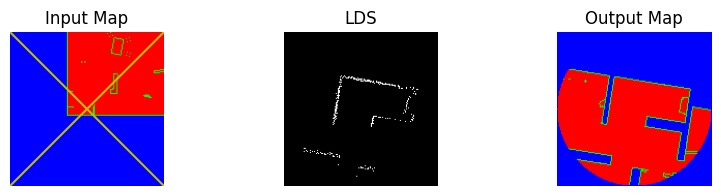

input_map:  (149, 149, 3)
lds_map:    (149, 149)
output_map: (149, 149, 3)
adlo:       [0. 0. 0. 0.]
metadata:   [2.0000000e+00 3.0000000e+00 1.0503165e+04 2.8729492e+03 0.0000000e+00
 8.2197345e+02 1.5362753e+03 7.4337691e-01]


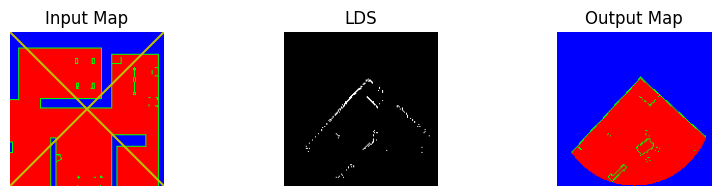

In [ ]:
slam_data.show_dataset(train_data, num=2, sample_types=3)

## SLAM Model
The SLAM model is a two-headed two-tailed extension of a U-Net. It takes two image-like inputs, which go through independent down-scaling, followed by combined up-scaling to a single image-like output. An additional output path is taken from the bottom of the U-Net and is used for location tracking.

![Image](https://raw.githubusercontent.com/malcolmlett/robovac/main/doc/Diagrams-slam-model.drawio.png?v=1)

**Data structures**

The inputs are:
* Map Input - square semantic map window (`H x W x 3`) taken from the global map at the current tracked position. This is oriented to the global map (no rotations applied) and aligned to the map pixels (no sub-pixel interpolations are applied). As location tracking incurs some errors, the centre of this map only approximately represents the agent's current location. When perfoming _global localisation_, the input map is a sample from any location on the global map. The first map input will be blank when kicking off exploration in an entirely unknown environment.

* LDS Input - square occupancy map (`H x W x 1`) computed from the LDS sensor data. The computed map is oriented (rotated) according to the current tracked orientation, which is encoded relative to the global map. This means that an accurate orientation tracking will result in an LDS map with the same orientation as the global map, regardless of the agent's true orientation, simplifying the task of the network. Furthermore, an attempt is made to align the LDS map pixel grid to that of the global map, in order to minimise false-positive delta location predictions. This is achieved by shifting the agent's location by up to +/- 0.5 pixels relative to the centre of the LDS map, based on the estimated tracked location. LDS input is always present regardless of operating mode.

The outputs are:
* Map Output - a square semantic map (`H x W x 3`) representing a revised version of the semantic map input, ready to be applied as an update onto the global map. It should incorporate information from the original semantic map input, with adjustments based on new information from the LDS input. For example, it may fill in walls that were previously unknown, or improve the accuracy of those wall locations. If the tracking of the agent location was inaccurate, the new LDS data should be shifted and rotated as needed in order to incorporate it into the revised semantic map. There are two exceptions to that rule. 1) when kicking off exploration in a new environment, the input semantic map is blank, and the output map should be aligned without rotation to the LDS input. 2) when performing global localisation, the semantic map input may be unrelated to the LDS input and the map output is ignored.

* Accept, Delta Location & Orientation (ADLO) Output - location tracking update. This is a size-4 vector made of three separate components:
  * Accept, in range 0.0 .. 1.0 - probability that the agent is located within the bounds of the input semantic map. When performing exploration and navigation a low probability is used to indicate that the agent has been unexpectedly moved. When performing global localisation, the window with the highest accept probability is chosen as the new location.
  * Delta Location (x, y) in range -0.5 .. +0.5 as fraction of window width/height - adjustment required to the agent location tracking.
  * Delta Orientation in range -1.0 .. +1.0 as fraction of 180-degrees - adjustment required to the agent orientation tracking.

The independent down-scaling of the two inputs reflects the fact that they may have a slight orientation difference at best, and at worst may represent completely different sections of the environment. By the middle layer, the network should have sufficient information to identify those discrepancies and to adjust for them. On the up-scale path, the network should use that information to conditionally choose which of the two inputs are used in construction of the final output.

The U-Net requires its inputs to have height and width dimensions that are a multiple of 16, whereas the max range of the LDS data translates to a 149x149 window size. For the sake of simplicity, I just work consistently with 149x149 maps outside of the model and have the model apply input padding to 160x160 and output cropping back to 149x149.

**Final Activations**

The output map uses softmax along its channel dimension for conversion from logits to probabilities. The Accept output uses a sigmoid function to convert from logit to binary classification probability. In practice, the softmax and sigmoid activation functions are pushed into the loss function as is commonly done for improved numerical stability. The Delta Location and Orientation outputs require a linear function, and so I simply apply no activation function there. For the sake of allowing the individual neurons to output in the range -1.0 .. +1.0, being the generally accepted optimum range, I apply a static x0.5 factor to the Delta X,Y outputs to get them into the required -0.5 .. +0.5 range. This is almost certainly completely superfluous.

**Overfitting Protection**

Dropout at a rate of 30% is added to 4th down-scale block of each input path, and to the bottom block after first concatenation. This particular configuration is a naive copy-paste from the example U-Net that this architecture was originally based on (taken from the [Deep Learning Specialization](https://www.coursera.org/specializations/deep-learning) course by Andrew Ng on Coursera).

**Summary**

In total, the model has:
* 68 layers (36 with trainable parameters)
* 12.3M trainable parameters
* 94MB memory usage with optimizer params included
* takes about 300ms per train step with batch size 32 on a Google Colab T4 GPU.

The code to construct the model has been rolled into the `slam_models` module, and can be executed as follows:
```python
import slam_models
map_shape = (149, 149, 3)
model = slam_models.slam_model(map_shape)
```

## Training

**Loss Functions**

During training I use a mixture of loss functions for the different outputs:
* Map output - categorical cross-entropy loss
* Accept output - binary cross-entropy loss
* Delta Location & Orientation (DLO) output - importance-weighted L1 error

Furthermore, I use customised loss functions to cater to a number of special cases:
* ignores map output if the expected output map is blank
* ignore DLO values if the expected Accept value is 0.0 (reject)
* computation of importance-weighted L1 error against DLO.

When operating in exploration and navigation modes, the navigation errors are typically small but accuracy is of high importance. In contrast, when performing global localisation, the navigation errors are typically large but of low importance. Thus I want the loss function to apply importance-weighting.

I first scale the L1 loss distances so they tend to fall in the range 0.0 to 1.0, making the rest of the maths easier. Then I apply the following function, which gives scaled loss values at zero a 4x weight factor, values at 0.2 a 2.5x weight factor, and values at 1.0 a 1.0x weight factor:
$$importance = \frac{4}{1 + 3*scaledLoss}$$

**Metrics**

In addition to custom loss functions, I use a number of custom metrics to get a better understanding of model performance during training.

These are:
* `adlo_loss` - just the ADLO component of the loss function
* `map_loss` - just the output map component of the loss function
* `map_accuracy` - percentage of correct category predictions, ignoring where expected output map is blank
* `obstruction_accuracy` - like `map_accuracy` except that it considers only pixels that are flagged as obstructions in _either_ the actual output or the expected output (or both)
* `accept_accuracy` - percentage of correct Accept outputs (after conversion to binary with a threshold at 0.5)
* `loc_error` - RMS error on the `delta location` output, ignoring where expected Accept = 0.0
* `orientation_error` - mean absolute error on the 'delta orientation` output, ignoring where expected Accept = 0.0

The custom loss functions are also available within the `slam_models` python module, and can be automatically compiled into the

```python
import slam_models
map_shape = (149, 149, 3)
model = slam_models.slam_model(map_shape, compile=True, verbose_history=True)
```

### Model-based Dataset Revision

As discussed above, there are some problems with the way that the input semantic maps are generated within our training dataset. In reality, our SLAM model will be used in a way that is akin to an RNN: the output state generated from one iteration of the model is used as input to the next iteration of the model. Training the CNN-UNet as an RNN would considerably slow down training, so we are attempting to approximate that through careful crafting of training data.

During the initial epochs of training I use semantic map inputs sampled directly from the ground-truth data. This is highly artificial and not representative of how the model will be used, but it provides a good enough starting point.

I then _revise_ the dataset using the model.

The basic outline is as follows:
1. Take a number of samples from the ground truth floorplan, covering the entire area of the floorplan, generating semantic map windows and LDS maps for each sample.
2. Use the model to produce predicted semantic maps for each individual sample.
3. Construct a global map from those samples in a way similar to how the SLAM model would be used when in operation.
4. Replace the input maps in the dataset by taking new samples from this global map.

In order to better simulate the differences between complete and partially complete global maps during exploration, I apply a number of additional randomly controlled adjustments for each revised input semantic map:
1. Let n = a uniform random number in the range 0 to 5
2. Of the samples taken to generate the new global map and which overlap onto the semantic map window being generated, pick only n of those samples
3. Use only those samples and construct a partially complete global map, and then take the semantic map window from it.

This significantly increases the range of variations applied to the 3 sample types that have input maps, and ensures that they are more realistic. Some examples of how these revised input maps may appear are given here:

![Image](https://raw.githubusercontent.com/malcolmlett/robovac/main/doc/example-revised-input-maps.png)

Lastly, to ensure a smooth learning process, I gradually introduce the model-based revised datasets as training proceeds.

This creates a training regime as follows:
1. First few training epochs - input maps from ground-truth floorplans
2. Use current state of model to produce a revised dataset. Merge that with the original according to a weight that initially favours the original dataset.
3. Train for a further few epochs
4. Increase the weight and repeat from step 2.
5. Continue looping until weight reaches 100% favouring revised dataset and then continue from then on revising the dataset every few epochs until training is complete.

I've found the following hyperpameters to work well while balancing the computational overhead of the dataset revisement process:
* Train in batches of 10 epochs, then revise dataset
* Scale weight from 0% to 100% over first 100 epochs (10 epoch-batches)
* Use 100% model-revised dataset from then on.

## Let's do it
Finally, we are in a position to train the model (or used a pre-trained one if it's available).

Caveat:
* I find I need to run this on a High-RAM environment within Colab. There seems to be a memory leak during model training that crops up on a normal environment and causes it to get OOM-killed before training completes. Frustratingly the memory leak doesn't occur when on a High-RAM, showing that it doesn't fundamentally need the extra cost of using High RAM.

In [ ]:
# Load model if available
if os.path.isfile('slam-model.npz'):
  model = tf.keras.models.load_model('slam-model.keras')
else:
  print(f"Sorry, pre-generated slam model not available, you'll need to train it.")

Sorry, pre-generated slam model not available, you'll need to train it.


map_shape: (149, 149, 3)
Added final cropping layer: w=11, h=11
Prepared SLAM model
  Map shape:        (149, 149, 3) + padding (11, 11, 0)
  Skip-connections: concat
  Output scaling:   logits
  DLO encoding:     linear/importance
  Inputs:           [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=None, name=map_input>, <KerasTensor shape=(None, 149, 149), dtype=float32, sparse=None, name=lds_input>]
  Outputs:          [<KerasTensor shape=(None, 149, 149, 3), dtype=float32, sparse=False, name=keras_tensor_51>, <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_57>]
  Compiled:         True
Epochs 0 to 9 with inputs like:


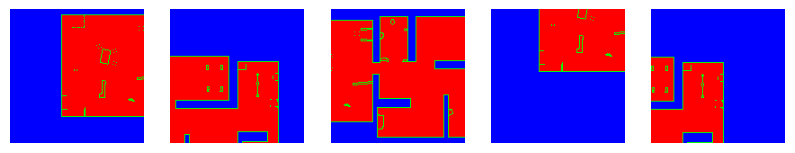

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - adlo_output_accept_accuracy: 0.6468 - adlo_output_adlo_loss: 5.0685 - adlo_output_loc_error: 0.4414 - adlo_output_orientation_error: 0.5419 - loss: 5.9698 - map_output_map_accuracy: 0.5529 - map_output_map_loss: 0.8993 - map_output_obstruction_accuracy: 0.0233
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 383ms/step - adlo_output_accept_accuracy: 0.7621 - adlo_output_adlo_loss: 1.2789 - adlo_output_loc_error: 0.1028 - adlo_output_orientation_error: 0.1973 - loss: 1.9283 - map_output_map_accuracy: 0.6924 - map_output_map_loss: 0.6490 - map_output_obstruction_accuracy: 0.0034
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 387ms/step - adlo_output_accept_accuracy: 0.7567 - adlo_output_adlo_loss: 1.2557 - adlo_output_loc_error: 0.1050 - adlo_output_orientation_error: 0.2006 - loss: 1.8822 - map_output_map_accuracy: 0.7055 - map_output_map_loss: 0.6263 - map_output_obstruction_accuracy: 0.0761
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 387ms/step - 

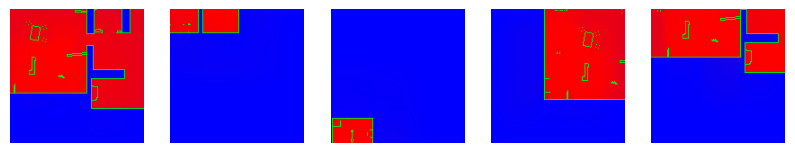

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 384ms/step - adlo_output_accept_accuracy: 0.7570 - adlo_output_adlo_loss: 1.1750 - adlo_output_loc_error: 0.1096 - adlo_output_orientation_error: 0.1911 - loss: 1.6426 - map_output_map_accuracy: 0.8000 - map_output_map_loss: 0.4685 - map_output_obstruction_accuracy: 0.2139
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 392ms/step - adlo_output_accept_accuracy: 0.7658 - adlo_output_adlo_loss: 1.1592 - adlo_output_loc_error: 0.1064 - adlo_output_orientation_error: 0.1953 - loss: 1.5916 - map_output_map_accuracy: 0.8200 - map_output_map_loss: 0.4325 - map_output_obstruction_accuracy: 0.2701
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 387ms/step - adlo_output_accept_accuracy: 0.7614 - adlo_output_adlo_loss: 1.1493 - adlo_output_loc_error: 0.1004 - adlo_output_orientation_error: 0.1944 - loss: 1.5805 - map_output_map_accuracy: 0.8199 - map_output_map_loss: 0.4309 - map_output_obstruction_accuracy: 0.2521
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 385ms/step

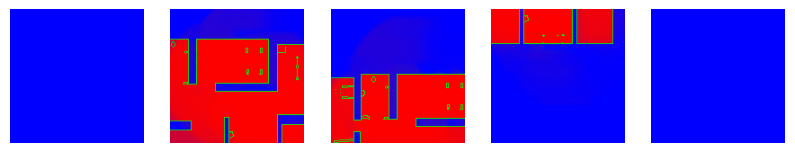

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step - adlo_output_accept_accuracy: 0.7562 - adlo_output_adlo_loss: 1.1186 - adlo_output_loc_error: 0.1121 - adlo_output_orientation_error: 0.2039 - loss: 1.4733 - map_output_map_accuracy: 0.8578 - map_output_map_loss: 0.3550 - map_output_obstruction_accuracy: 0.2581
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 394ms/step - adlo_output_accept_accuracy: 0.7766 - adlo_output_adlo_loss: 1.0742 - adlo_output_loc_error: 0.1107 - adlo_output_orientation_error: 0.2016 - loss: 1.4436 - map_output_map_accuracy: 0.8497 - map_output_map_loss: 0.3696 - map_output_obstruction_accuracy: 0.2630
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 389ms/step - adlo_output_accept_accuracy: 0.7861 - adlo_output_adlo_loss: 1.0770 - adlo_output_loc_error: 0.1072 - adlo_output_orientation_error: 0.2154 - loss: 1.4696 - map_output_map_accuracy: 0.8414 - map_output_map_loss: 0.3926 - map_output_obstruction_accuracy: 0.2419
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 385ms/step

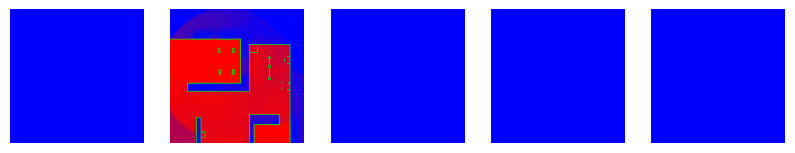

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step - adlo_output_accept_accuracy: 0.9658 - adlo_output_adlo_loss: 0.6496 - adlo_output_loc_error: 0.0931 - adlo_output_orientation_error: 0.1611 - loss: 0.9727 - map_output_map_accuracy: 0.8743 - map_output_map_loss: 0.3236 - map_output_obstruction_accuracy: 0.2924
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 392ms/step - adlo_output_accept_accuracy: 0.9360 - adlo_output_adlo_loss: 0.7056 - adlo_output_loc_error: 0.0935 - adlo_output_orientation_error: 0.1736 - loss: 1.0358 - map_output_map_accuracy: 0.8674 - map_output_map_loss: 0.3306 - map_output_obstruction_accuracy: 0.2744
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 386ms/step - adlo_output_accept_accuracy: 0.9392 - adlo_output_adlo_loss: 0.6999 - adlo_output_loc_error: 0.0970 - adlo_output_orientation_error: 0.1668 - loss: 1.0621 - map_output_map_accuracy: 0.8582 - map_output_map_loss: 0.3620 - map_output_obstruction_accuracy: 0.2429
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 384ms/step

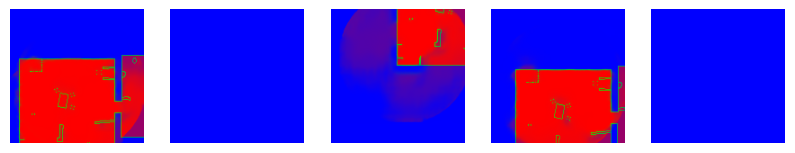

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step - adlo_output_accept_accuracy: 0.9934 - adlo_output_adlo_loss: 0.4565 - adlo_output_loc_error: 0.0794 - adlo_output_orientation_error: 0.1298 - loss: 0.7127 - map_output_map_accuracy: 0.9036 - map_output_map_loss: 0.2566 - map_output_obstruction_accuracy: 0.2678
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 393ms/step - adlo_output_accept_accuracy: 0.9927 - adlo_output_adlo_loss: 0.4906 - adlo_output_loc_error: 0.0775 - adlo_output_orientation_error: 0.1572 - loss: 0.7516 - map_output_map_accuracy: 0.9042 - map_output_map_loss: 0.2607 - map_output_obstruction_accuracy: 0.3066
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 388ms/step - adlo_output_accept_accuracy: 0.9964 - adlo_output_adlo_loss: 0.4648 - adlo_output_loc_error: 0.0816 - adlo_output_orientation_error: 0.1405 - loss: 0.7006 - map_output_map_accuracy: 0.9147 - map_output_map_loss: 0.2361 - map_output_obstruction_accuracy: 0.3174
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 386ms/step

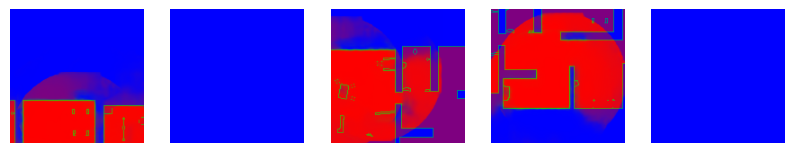

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 386ms/step - adlo_output_accept_accuracy: 0.9996 - adlo_output_adlo_loss: 0.4033 - adlo_output_loc_error: 0.0649 - adlo_output_orientation_error: 0.1290 - loss: 0.6279 - map_output_map_accuracy: 0.9185 - map_output_map_loss: 0.2248 - map_output_obstruction_accuracy: 0.3175
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 393ms/step - adlo_output_accept_accuracy: 0.9946 - adlo_output_adlo_loss: 0.3652 - adlo_output_loc_error: 0.0590 - adlo_output_orientation_error: 0.1059 - loss: 0.6080 - map_output_map_accuracy: 0.9107 - map_output_map_loss: 0.2427 - map_output_obstruction_accuracy: 0.2952
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 386ms/step - adlo_output_accept_accuracy: 0.9989 - adlo_output_adlo_loss: 0.3373 - adlo_output_loc_error: 0.0570 - adlo_output_orientation_error: 0.0941 - loss: 0.5503 - map_output_map_accuracy: 0.9234 - map_output_map_loss: 0.2133 - map_output_obstruction_accuracy: 0.3506
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 384ms/step

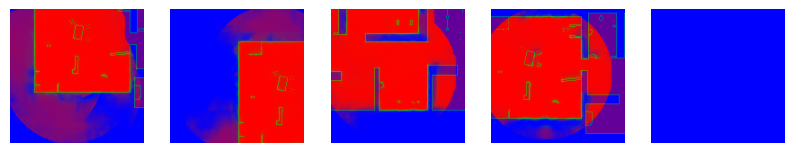

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step - adlo_output_accept_accuracy: 0.9984 - adlo_output_adlo_loss: 0.3000 - adlo_output_loc_error: 0.0539 - adlo_output_orientation_error: 0.0859 - loss: 0.5052 - map_output_map_accuracy: 0.9274 - map_output_map_loss: 0.2054 - map_output_obstruction_accuracy: 0.3414
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 393ms/step - adlo_output_accept_accuracy: 0.9983 - adlo_output_adlo_loss: 0.2552 - adlo_output_loc_error: 0.0454 - adlo_output_orientation_error: 0.0689 - loss: 0.4237 - map_output_map_accuracy: 0.9411 - map_output_map_loss: 0.1686 - map_output_obstruction_accuracy: 0.3814
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 387ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.2555 - adlo_output_loc_error: 0.0429 - adlo_output_orientation_error: 0.0707 - loss: 0.4343 - map_output_map_accuracy: 0.9379 - map_output_map_loss: 0.1786 - map_output_obstruction_accuracy: 0.3584
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step

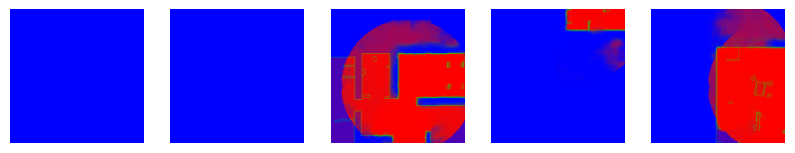

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 384ms/step - adlo_output_accept_accuracy: 0.9994 - adlo_output_adlo_loss: 0.2172 - adlo_output_loc_error: 0.0397 - adlo_output_orientation_error: 0.0528 - loss: 0.3857 - map_output_map_accuracy: 0.9424 - map_output_map_loss: 0.1687 - map_output_obstruction_accuracy: 0.3719
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 392ms/step - adlo_output_accept_accuracy: 0.9987 - adlo_output_adlo_loss: 0.2439 - adlo_output_loc_error: 0.0376 - adlo_output_orientation_error: 0.0657 - loss: 0.3949 - map_output_map_accuracy: 0.9470 - map_output_map_loss: 0.1511 - map_output_obstruction_accuracy: 0.3761
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 388ms/step - adlo_output_accept_accuracy: 0.9987 - adlo_output_adlo_loss: 0.2408 - adlo_output_loc_error: 0.0381 - adlo_output_orientation_error: 0.0604 - loss: 0.3988 - map_output_map_accuracy: 0.9444 - map_output_map_loss: 0.1581 - map_output_obstruction_accuracy: 0.3676
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step

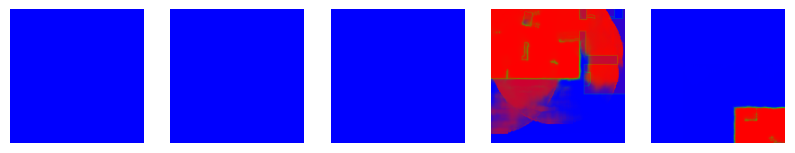

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 384ms/step - adlo_output_accept_accuracy: 0.9996 - adlo_output_adlo_loss: 0.2170 - adlo_output_loc_error: 0.0373 - adlo_output_orientation_error: 0.0586 - loss: 0.3592 - map_output_map_accuracy: 0.9513 - map_output_map_loss: 0.1426 - map_output_obstruction_accuracy: 0.3761
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 392ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1862 - adlo_output_loc_error: 0.0312 - adlo_output_orientation_error: 0.0488 - loss: 0.3215 - map_output_map_accuracy: 0.9526 - map_output_map_loss: 0.1353 - map_output_obstruction_accuracy: 0.3812
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 386ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1756 - adlo_output_loc_error: 0.0310 - adlo_output_orientation_error: 0.0461 - loss: 0.3050 - map_output_map_accuracy: 0.9545 - map_output_map_loss: 0.1294 - map_output_obstruction_accuracy: 0.3821
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 386ms/step

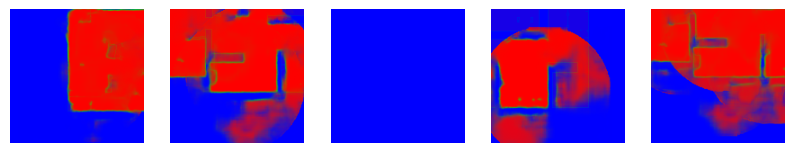

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step - adlo_output_accept_accuracy: 0.9839 - adlo_output_adlo_loss: 0.2695 - adlo_output_loc_error: 0.0384 - adlo_output_orientation_error: 0.0622 - loss: 0.5261 - map_output_map_accuracy: 0.9118 - map_output_map_loss: 0.2566 - map_output_obstruction_accuracy: 0.1796
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 392ms/step - adlo_output_accept_accuracy: 0.8915 - adlo_output_adlo_loss: 0.8620 - adlo_output_loc_error: 0.0813 - adlo_output_orientation_error: 0.1308 - loss: 1.2644 - map_output_map_accuracy: 0.8450 - map_output_map_loss: 0.4034 - map_output_obstruction_accuracy: 0.1375
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 386ms/step - adlo_output_accept_accuracy: 0.9109 - adlo_output_adlo_loss: 0.7596 - adlo_output_loc_error: 0.0844 - adlo_output_orientation_error: 0.1425 - loss: 1.2029 - map_output_map_accuracy: 0.8269 - map_output_map_loss: 0.4441 - map_output_obstruction_accuracy: 0.1618
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 384ms/step

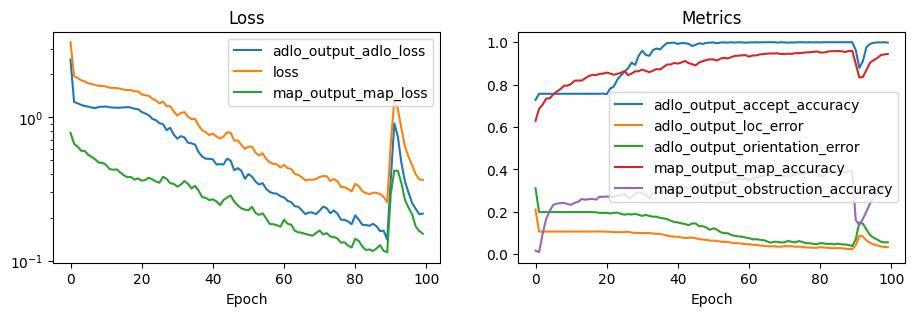

NameError: name 'true' is not defined

In [ ]:
map_shape = next(iter(train_data))[0][0].shape
print(f"map_shape: {map_shape}")
np.random.seed(42)
tf.random.set_seed(42)

epochs = 100
dataset_revision_period = 10
batch_size = 32

model = slam_models.slam_model(map_shape, compile=True, verbose_history=True)
model_train_data = train_data.map(slam_data.for_model_training)\
  .shuffle(buffer_size=len(train_data))\
  .batch(batch_size)\
  .prefetch(tf.data.experimental.AUTOTUNE)

start = timer()
agg_history = tf.keras.callbacks.History()
for i in range(0, math.ceil(epochs/dataset_revision_period) * dataset_revision_period, dataset_revision_period):
  if i > 0:
    weight = slam_data.DatasetRevisor.compute_model_revisement_weight(i, 100)
    print(f"Model-prediction weight: {weight}")
    revisor = slam_data.DatasetRevisor(floorplan, model, weight=weight)
    revisor.prepare()
    model_train_data = train_data.map(revisor.map).map(slam_data.for_model_training)\
      .shuffle(buffer_size=len(train_data))\
      .batch(batch_size)\
      .prefetch(tf.data.experimental.AUTOTUNE)
  print(f"Epochs {i} to {i+dataset_revision_period-1} with inputs like:")
  slam_data.show_input_maps(model_train_data)
  model_history = model.fit(model_train_data, epochs=dataset_revision_period, callbacks=[agg_history])
duration = (timer() - start)

print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
slam_data.show_predictions(model, train_data, 8, model_based_inputs=True, floorplan=floorplan, show_classes='pred')

## Training Results
Here we can look at the training results against each raw training data sample.

In the plots below:
* Text before - ground-truth and actual ADLO outputs (with/without sigmoid scaling on Accept output), plus the metadata vector
* first 3 images (Map, LDS, Ground Truth) - the raw training data
* Predicted - map output from model after argmax applied
* Pred Scaled - map output from model after softmax applied
* Pred: 0/1/2 - individual channels after softmax applied

A note of caution:
* remember that for Sample Type 2 we ignore the map output during training. Thus the model tends to produce weird smudgy results for those scenarios. Use the second value of the metadata vector to check the sample type.

Generating 93 LDS maps...
Generating semantic maps...
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 5.4271564e+00  2.2809235e-03  7.6732016e-04 -1.4494811e-03]
adlo-pred scaled: [ 9.9562365e-01  2.2809235e-03  7.6732016e-04 -1.4494811e-03]
metadata:         [2.0000000e+00 0.0000000e+00           nan           nan           nan
 8.2396826e+03 5.5399946e+03 2.2490387e+00]


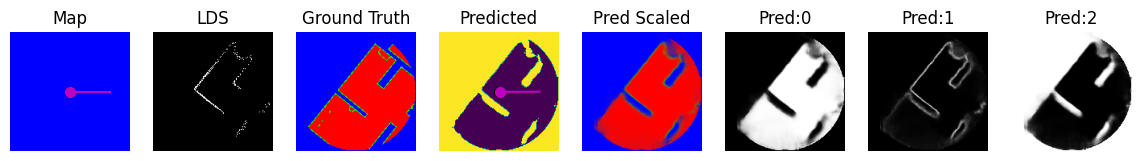

adlo:             [ 1.          0.06650611 -0.1320825  -0.31531525]
adlo-pred raw:    [ 3.5879872   0.0692509  -0.12168239 -0.21698685]
adlo-pred scaled: [ 0.97309023  0.0692509  -0.12168239 -0.21698685]
metadata:         [2.0000000e+00 2.0000000e+00 1.3173024e+04 1.5449518e+03 0.0000000e+00
 1.3642829e+04 6.1190906e+02 2.2837534e+00]


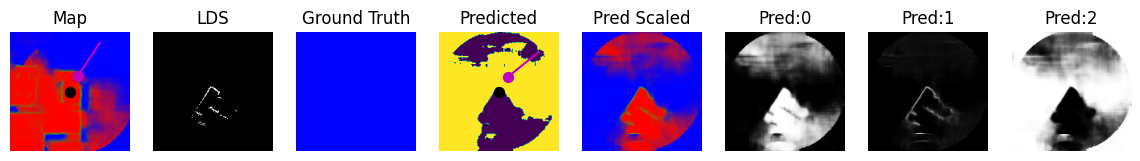

adlo:             [ 1.          0.08753846  0.48659375 -0.07261062]
adlo-pred raw:    [ 8.6439991e+00 -6.7551015e-03  3.0683881e-01 -4.3818835e-02]
adlo-pred scaled: [ 0.99982387 -0.0067551   0.3068388  -0.04381884]
metadata:         [2.0000000e+00 2.0000000e+00 5.6892510e+03 1.7544061e+03 0.0000000e+00
 6.3076309e+03 5.1917485e+03 1.1705631e+00]


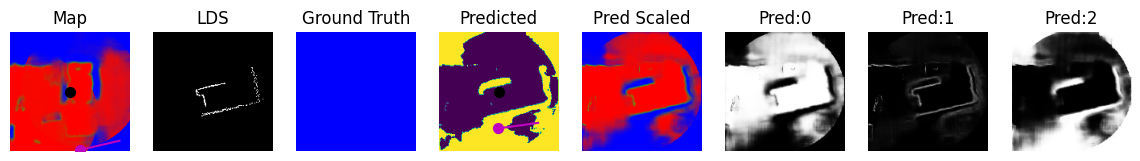

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 5.4271564e+00  2.2809235e-03  7.6732016e-04 -1.4494811e-03]
adlo-pred scaled: [ 9.9562365e-01  2.2809235e-03  7.6732016e-04 -1.4494811e-03]
metadata:         [2.0000000e+00 0.0000000e+00           nan           nan           nan
 1.2064993e+04 1.7325601e+03 2.9138200e+00]


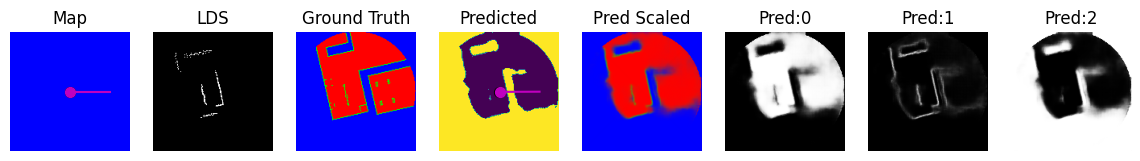

adlo:             [ 1.         -0.04257149 -0.08866958  0.0635903 ]
adlo-pred raw:    [ 8.0628777e+00 -4.5406325e-03 -4.7045141e-02  5.1230274e-02]
adlo-pred scaled: [ 0.99968505 -0.00454063 -0.04704514  0.05123027]
metadata:         [ 2.0000000e+00  1.0000000e+00  3.2739753e+03  5.3642241e+03
  0.0000000e+00  2.9732466e+03  4.7378540e+03 -4.6301708e-01]


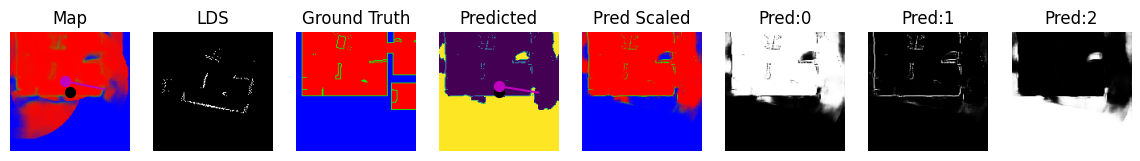

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 5.4271564e+00  2.2809235e-03  7.6732016e-04 -1.4494811e-03]
adlo-pred scaled: [ 9.9562365e-01  2.2809235e-03  7.6732016e-04 -1.4494811e-03]
metadata:         [ 2.0000000e+00  0.0000000e+00            nan            nan
            nan  9.7502002e+03  1.2486838e+03 -1.0998367e+00]


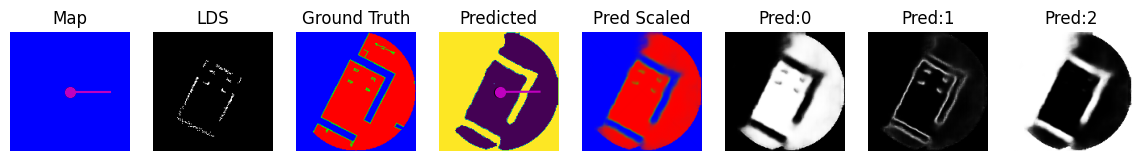

adlo:             [ 1.0000000e+00 -4.5766373e-04  2.0432066e-02  4.3668937e-02]
adlo-pred raw:    [3.996327   0.00563446 0.02378522 0.03192094]
adlo-pred scaled: [0.9819488  0.00563446 0.02378522 0.03192094]
metadata:         [ 2.0000000e+00  1.0000000e+00  1.1866017e+04  2.6124204e+03
  0.0000000e+00  1.1862783e+04  2.7567542e+03 -5.7919192e-01]


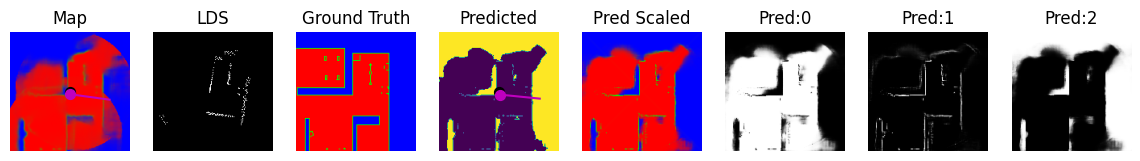

adlo:             [ 1.         -0.02623202 -0.06905483  0.02933878]
adlo-pred raw:    [ 5.699729   -0.01738542 -0.05768543  0.01507071]
adlo-pred scaled: [ 0.9966642  -0.01738542 -0.05768543  0.01507071]
metadata:         [2.0000000e+00 1.0000000e+00 1.0519315e+04 6.4943457e+03 0.0000000e+00
 1.0334010e+04 6.0065361e+03 5.9592706e-01]


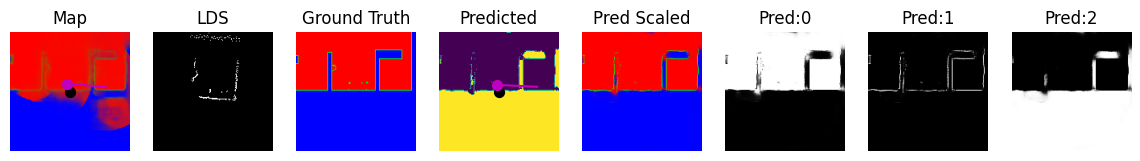

In [ ]:
slam_data.show_predictions(model, train_data, 8, model_based_inputs=True, floorplan=floorplan, show_classes='pred')

In [ ]:
# Optionally, save the model
tf.keras.models.save_model(model, 'slam-model-100epochs.keras')

In [ ]:
#model = tf.keras.models.load_model('slam-model-100epochs.keras')

Model-prediction weight: 1.0
Generating 97 LDS maps...
Generating semantic maps...
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 955ms/step
Epochs 0 to 9 with inputs like:


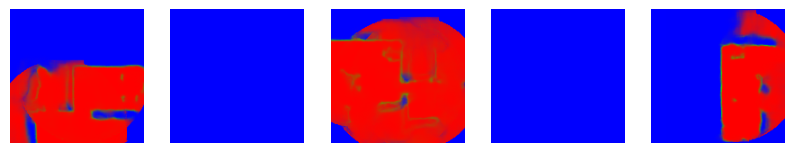

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 621ms/step - adlo_output_accept_accuracy: 0.9843 - adlo_output_adlo_loss: 0.3146 - adlo_output_loc_error: 0.0469 - adlo_output_orientation_error: 0.0746 - loss: 0.5951 - map_output_map_accuracy: 0.9045 - map_output_map_loss: 0.2807 - map_output_obstruction_accuracy: 0.1094
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 392ms/step - adlo_output_accept_accuracy: 0.9891 - adlo_output_adlo_loss: 0.3032 - adlo_output_loc_error: 0.0433 - adlo_output_orientation_error: 0.0736 - loss: 0.5623 - map_output_map_accuracy: 0.9068 - map_output_map_loss: 0.2590 - map_output_obstruction_accuracy: 0.1295
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 388ms/step - adlo_output_accept_accuracy: 0.9984 - adlo_output_adlo_loss: 0.2573 - adlo_output_loc_error: 0.0430 - adlo_output_orientation_error: 0.0621 - loss: 0.5031 - map_output_map_accuracy: 0.9129 - map_output_map_loss: 0.2459 - map_output_obstruction_accuracy: 0.1273
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 383ms/step

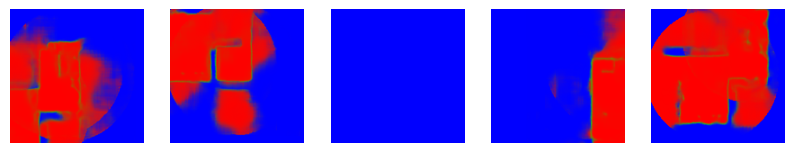

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 384ms/step - adlo_output_accept_accuracy: 0.9964 - adlo_output_adlo_loss: 0.2228 - adlo_output_loc_error: 0.0370 - adlo_output_orientation_error: 0.0517 - loss: 0.4228 - map_output_map_accuracy: 0.9299 - map_output_map_loss: 0.2002 - map_output_obstruction_accuracy: 0.1473
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 394ms/step - adlo_output_accept_accuracy: 0.9987 - adlo_output_adlo_loss: 0.2014 - adlo_output_loc_error: 0.0334 - adlo_output_orientation_error: 0.0510 - loss: 0.3967 - map_output_map_accuracy: 0.9312 - map_output_map_loss: 0.1953 - map_output_obstruction_accuracy: 0.1532
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 388ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.2057 - adlo_output_loc_error: 0.0333 - adlo_output_orientation_error: 0.0557 - loss: 0.3968 - map_output_map_accuracy: 0.9327 - map_output_map_loss: 0.1909 - map_output_obstruction_accuracy: 0.1491
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 385ms/step

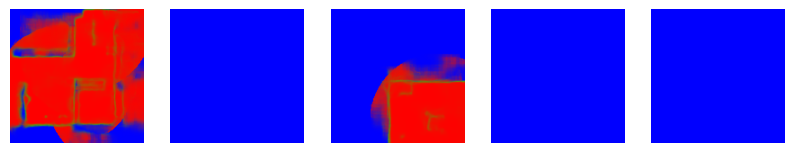

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 384ms/step - adlo_output_accept_accuracy: 0.9895 - adlo_output_adlo_loss: 0.2194 - adlo_output_loc_error: 0.0331 - adlo_output_orientation_error: 0.0515 - loss: 0.4038 - map_output_map_accuracy: 0.9353 - map_output_map_loss: 0.1843 - map_output_obstruction_accuracy: 0.1555
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 394ms/step - adlo_output_accept_accuracy: 0.9920 - adlo_output_adlo_loss: 0.1999 - adlo_output_loc_error: 0.0298 - adlo_output_orientation_error: 0.0498 - loss: 0.3956 - map_output_map_accuracy: 0.9313 - map_output_map_loss: 0.1961 - map_output_obstruction_accuracy: 0.1571
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 389ms/step - adlo_output_accept_accuracy: 0.9965 - adlo_output_adlo_loss: 0.2233 - adlo_output_loc_error: 0.0342 - adlo_output_orientation_error: 0.0569 - loss: 0.4372 - map_output_map_accuracy: 0.9242 - map_output_map_loss: 0.2139 - map_output_obstruction_accuracy: 0.1505
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 384ms/step

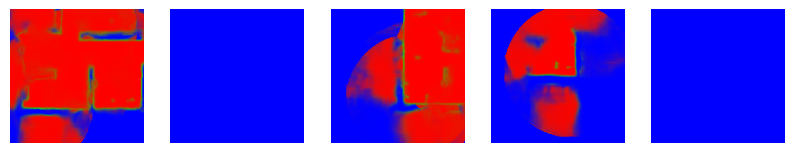

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 384ms/step - adlo_output_accept_accuracy: 0.9920 - adlo_output_adlo_loss: 0.2101 - adlo_output_loc_error: 0.0288 - adlo_output_orientation_error: 0.0462 - loss: 0.3778 - map_output_map_accuracy: 0.9404 - map_output_map_loss: 0.1676 - map_output_obstruction_accuracy: 0.1721
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 393ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1641 - adlo_output_loc_error: 0.0266 - adlo_output_orientation_error: 0.0453 - loss: 0.3259 - map_output_map_accuracy: 0.9429 - map_output_map_loss: 0.1618 - map_output_obstruction_accuracy: 0.1753
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 387ms/step - adlo_output_accept_accuracy: 0.9906 - adlo_output_adlo_loss: 0.2080 - adlo_output_loc_error: 0.0290 - adlo_output_orientation_error: 0.0426 - loss: 0.3713 - map_output_map_accuracy: 0.9422 - map_output_map_loss: 0.1632 - map_output_obstruction_accuracy: 0.1779
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step

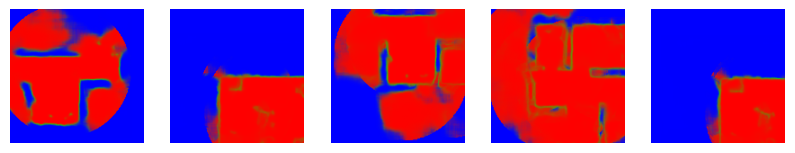

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 384ms/step - adlo_output_accept_accuracy: 0.9974 - adlo_output_adlo_loss: 0.1726 - adlo_output_loc_error: 0.0289 - adlo_output_orientation_error: 0.0429 - loss: 0.3255 - map_output_map_accuracy: 0.9458 - map_output_map_loss: 0.1530 - map_output_obstruction_accuracy: 0.1750
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 394ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1620 - adlo_output_loc_error: 0.0276 - adlo_output_orientation_error: 0.0388 - loss: 0.3190 - map_output_map_accuracy: 0.9441 - map_output_map_loss: 0.1570 - map_output_obstruction_accuracy: 0.1857
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 389ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1593 - adlo_output_loc_error: 0.0265 - adlo_output_orientation_error: 0.0422 - loss: 0.3025 - map_output_map_accuracy: 0.9490 - map_output_map_loss: 0.1432 - map_output_obstruction_accuracy: 0.1906
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 384ms/step

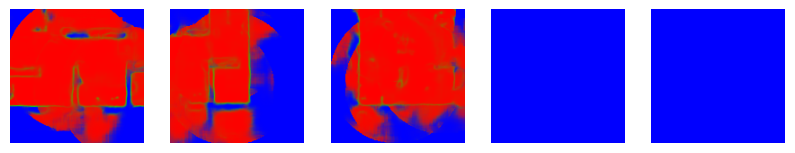

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 384ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1498 - adlo_output_loc_error: 0.0247 - adlo_output_orientation_error: 0.0369 - loss: 0.2948 - map_output_map_accuracy: 0.9489 - map_output_map_loss: 0.1449 - map_output_obstruction_accuracy: 0.1952
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 394ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1356 - adlo_output_loc_error: 0.0226 - adlo_output_orientation_error: 0.0354 - loss: 0.2714 - map_output_map_accuracy: 0.9520 - map_output_map_loss: 0.1357 - map_output_obstruction_accuracy: 0.1915
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 387ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1271 - adlo_output_loc_error: 0.0211 - adlo_output_orientation_error: 0.0342 - loss: 0.2599 - map_output_map_accuracy: 0.9532 - map_output_map_loss: 0.1328 - map_output_obstruction_accuracy: 0.1993
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step

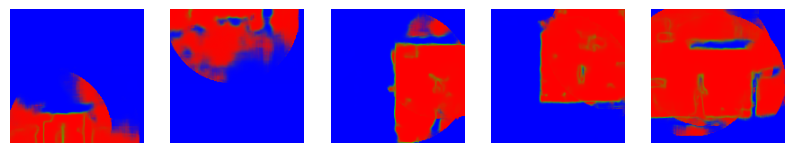

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step - adlo_output_accept_accuracy: 0.9981 - adlo_output_adlo_loss: 0.1365 - adlo_output_loc_error: 0.0241 - adlo_output_orientation_error: 0.0327 - loss: 0.2701 - map_output_map_accuracy: 0.9539 - map_output_map_loss: 0.1337 - map_output_obstruction_accuracy: 0.2077
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 393ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1192 - adlo_output_loc_error: 0.0196 - adlo_output_orientation_error: 0.0305 - loss: 0.2452 - map_output_map_accuracy: 0.9556 - map_output_map_loss: 0.1260 - map_output_obstruction_accuracy: 0.2087
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 387ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1194 - adlo_output_loc_error: 0.0183 - adlo_output_orientation_error: 0.0288 - loss: 0.2368 - map_output_map_accuracy: 0.9580 - map_output_map_loss: 0.1176 - map_output_obstruction_accuracy: 0.2228
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 384ms/step

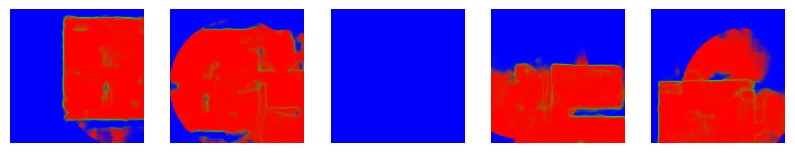

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 384ms/step - adlo_output_accept_accuracy: 0.9975 - adlo_output_adlo_loss: 0.1448 - adlo_output_loc_error: 0.0250 - adlo_output_orientation_error: 0.0341 - loss: 0.2820 - map_output_map_accuracy: 0.9524 - map_output_map_loss: 0.1373 - map_output_obstruction_accuracy: 0.2012
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 394ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1303 - adlo_output_loc_error: 0.0227 - adlo_output_orientation_error: 0.0328 - loss: 0.2677 - map_output_map_accuracy: 0.9520 - map_output_map_loss: 0.1374 - map_output_obstruction_accuracy: 0.2029
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 388ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1226 - adlo_output_loc_error: 0.0225 - adlo_output_orientation_error: 0.0284 - loss: 0.2428 - map_output_map_accuracy: 0.9574 - map_output_map_loss: 0.1202 - map_output_obstruction_accuracy: 0.2250
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step

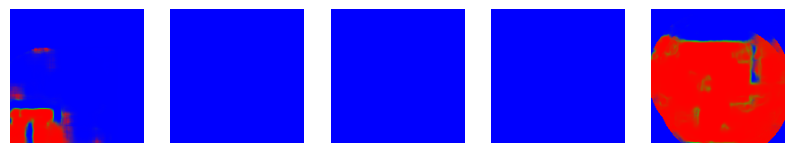

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 383ms/step - adlo_output_accept_accuracy: 0.9985 - adlo_output_adlo_loss: 0.1302 - adlo_output_loc_error: 0.0233 - adlo_output_orientation_error: 0.0355 - loss: 0.2493 - map_output_map_accuracy: 0.9585 - map_output_map_loss: 0.1192 - map_output_obstruction_accuracy: 0.2333
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 391ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1242 - adlo_output_loc_error: 0.0221 - adlo_output_orientation_error: 0.0309 - loss: 0.2498 - map_output_map_accuracy: 0.9560 - map_output_map_loss: 0.1259 - map_output_obstruction_accuracy: 0.2198
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 385ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1354 - adlo_output_loc_error: 0.0224 - adlo_output_orientation_error: 0.0355 - loss: 0.2718 - map_output_map_accuracy: 0.9523 - map_output_map_loss: 0.1364 - map_output_obstruction_accuracy: 0.2106
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 383ms/step

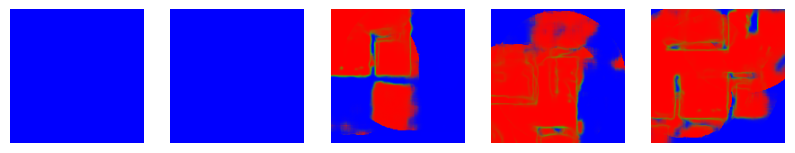

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 383ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1154 - adlo_output_loc_error: 0.0210 - adlo_output_orientation_error: 0.0284 - loss: 0.2282 - map_output_map_accuracy: 0.9602 - map_output_map_loss: 0.1127 - map_output_obstruction_accuracy: 0.2405
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 391ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1262 - adlo_output_loc_error: 0.0210 - adlo_output_orientation_error: 0.0336 - loss: 0.2336 - map_output_map_accuracy: 0.9616 - map_output_map_loss: 0.1074 - map_output_obstruction_accuracy: 0.2497
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 386ms/step - adlo_output_accept_accuracy: 1.0000 - adlo_output_adlo_loss: 0.1118 - adlo_output_loc_error: 0.0198 - adlo_output_orientation_error: 0.0276 - loss: 0.2128 - map_output_map_accuracy: 0.9637 - map_output_map_loss: 0.1011 - map_output_obstruction_accuracy: 0.2698
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 382ms/step

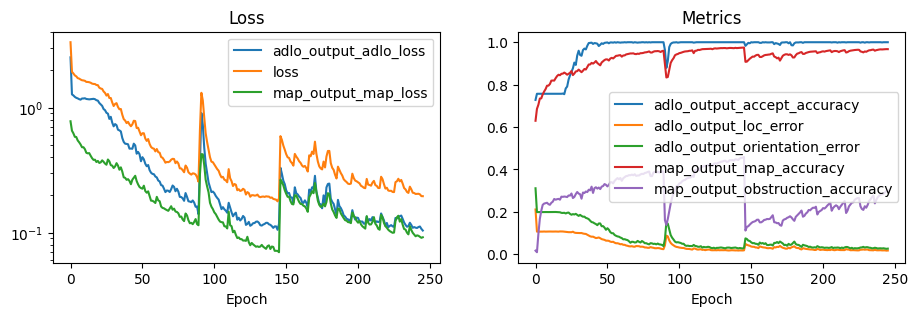

Generating 88 LDS maps...
Generating semantic maps...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 6.938162e+00 -1.826796e-03  1.338922e-03 -4.019255e-03]
adlo-pred scaled: [ 0.99903095 -0.0018268   0.00133892 -0.00401925]
metadata:         [2.0000000e+00 0.0000000e+00           nan           nan           nan
 8.2396826e+03 5.5399946e+03 2.2490387e+00]


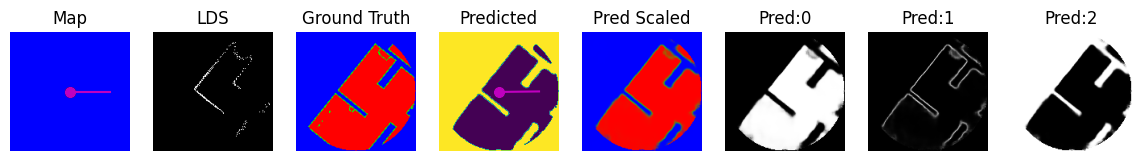

adlo:             [ 1.          0.06650611 -0.1320825  -0.31531525]
adlo-pred raw:    [ 6.4644976   0.07899716 -0.10913777 -0.2541702 ]
adlo-pred scaled: [ 0.9984446   0.07899716 -0.10913777 -0.2541702 ]
metadata:         [2.0000000e+00 2.0000000e+00 1.3173024e+04 1.5449518e+03 0.0000000e+00
 1.3642829e+04 6.1190906e+02 2.2837534e+00]


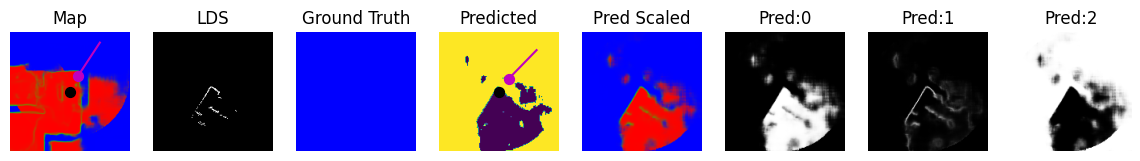

adlo:             [ 1.          0.08753846  0.48659375 -0.07261062]
adlo-pred raw:    [11.177747    0.14854006  0.63646585 -0.0824637 ]
adlo-pred scaled: [ 0.99998605  0.14854006  0.63646585 -0.0824637 ]
metadata:         [2.0000000e+00 2.0000000e+00 5.6892510e+03 1.7544061e+03 0.0000000e+00
 6.3076309e+03 5.1917485e+03 1.1705631e+00]


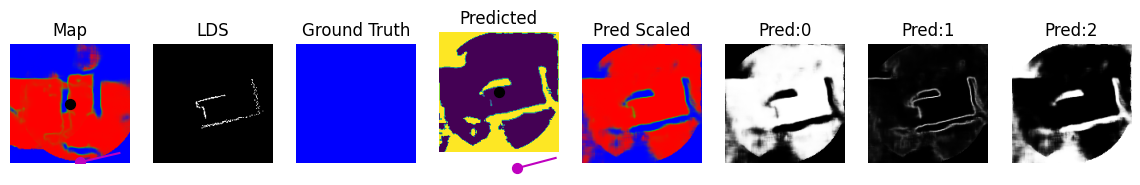

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 6.938162e+00 -1.826796e-03  1.338922e-03 -4.019255e-03]
adlo-pred scaled: [ 0.99903095 -0.0018268   0.00133892 -0.00401925]
metadata:         [2.0000000e+00 0.0000000e+00           nan           nan           nan
 1.2064993e+04 1.7325601e+03 2.9138200e+00]


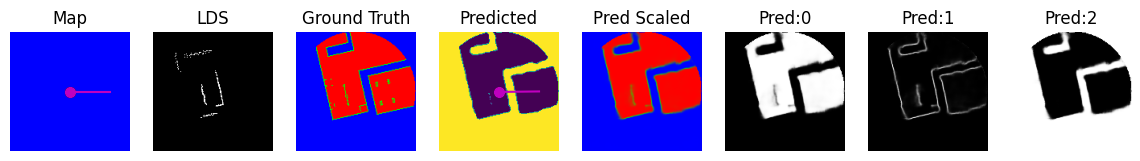

adlo:             [ 1.         -0.04257149 -0.08866958  0.0635903 ]
adlo-pred raw:    [10.512814   -0.03390763 -0.09735816  0.05482298]
adlo-pred scaled: [ 0.9999728  -0.03390763 -0.09735816  0.05482298]
metadata:         [ 2.0000000e+00  1.0000000e+00  3.2739753e+03  5.3642241e+03
  0.0000000e+00  2.9732466e+03  4.7378540e+03 -4.6301708e-01]


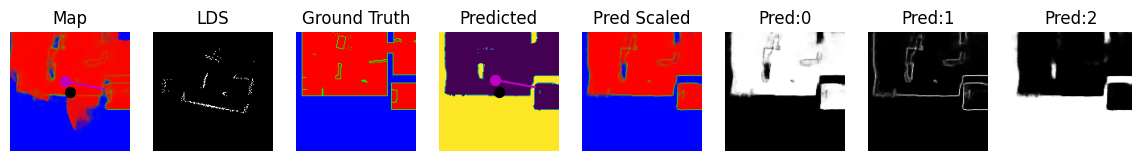

adlo:             [1. 0. 0. 0.]
adlo-pred raw:    [ 6.938162e+00 -1.826796e-03  1.338922e-03 -4.019255e-03]
adlo-pred scaled: [ 0.99903095 -0.0018268   0.00133892 -0.00401925]
metadata:         [ 2.0000000e+00  0.0000000e+00            nan            nan
            nan  9.7502002e+03  1.2486838e+03 -1.0998367e+00]


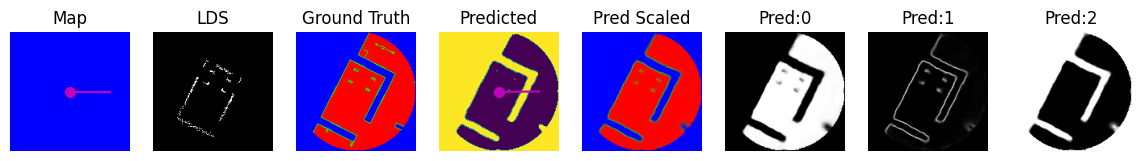

adlo:             [ 1.0000000e+00 -4.5766373e-04  2.0432066e-02  4.3668937e-02]
adlo-pred raw:    [ 8.6161156e+00 -5.8867084e-03  3.6156118e-02  3.8670279e-02]
adlo-pred scaled: [ 0.99981886 -0.00588671  0.03615612  0.03867028]
metadata:         [ 2.0000000e+00  1.0000000e+00  1.1866017e+04  2.6124204e+03
  0.0000000e+00  1.1862783e+04  2.7567542e+03 -5.7919192e-01]


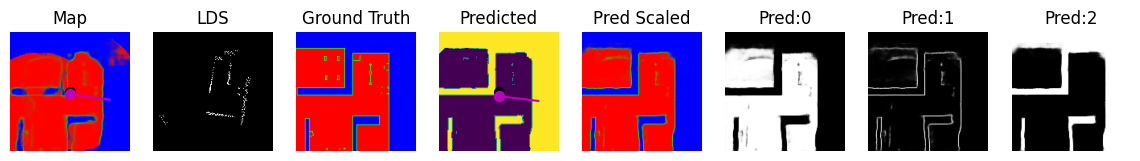

adlo:             [ 1.         -0.02623202 -0.06905483  0.02933878]
adlo-pred raw:    [ 8.133201   -0.02228118 -0.06033724  0.02213446]
adlo-pred scaled: [ 0.99970645 -0.02228118 -0.06033724  0.02213446]
metadata:         [2.0000000e+00 1.0000000e+00 1.0519315e+04 6.4943457e+03 0.0000000e+00
 1.0334010e+04 6.0065361e+03 5.9592706e-01]


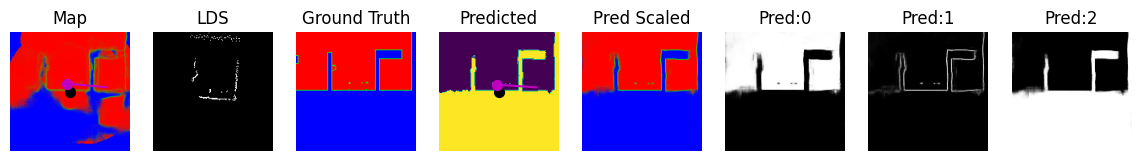

In [ ]:
# Train for an additional 100 epochs
for i in range(0, math.ceil(epochs/dataset_revision_period) * dataset_revision_period, dataset_revision_period):
  weight = 1.0
  print(f"Model-prediction weight: {weight}")
  revisor = slam_data.DatasetRevisor(floorplan, model, weight=weight)
  revisor.prepare()
  model_train_data = train_data.map(revisor.map).map(slam_data.for_model_training)\
    .shuffle(buffer_size=len(train_data))\
    .batch(batch_size)\
    .prefetch(tf.data.experimental.AUTOTUNE)
  print(f"Epochs {i} to {i+dataset_revision_period-1} with inputs like:")
  slam_data.show_input_maps(model_train_data)
  model_history = model.fit(model_train_data, epochs=dataset_revision_period, callbacks=[agg_history])
duration = (timer() - start)

print(f"Epochs: {epochs}, duration: {duration} sec")
display_history(model_history)
slam_data.show_predictions(model, train_data, 8, model_based_inputs=True, floorplan=floorplan, show_classes='pred')

In [ ]:
# Optionally, save the model
tf.keras.models.save_model(model, 'slam-model-200epochs.keras')